__Short summary__

In this notebook:
- [Предсказания по группам major](#major);
- [Отбор признаков в не fine-tuned модели](#nt_feature_selection).  

Отбор признаков - x первых признаков, отранжированных по p_value, коэф-ту корреляции с вектором labels, gridSearch logreg params + pca.

In [1]:
import os
import sys
from time import time
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint as pp
from tqdm.notebook import tqdm
from collections import Counter
import warnings
import itertools
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import matthews_corrcoef, accuracy_score, balanced_accuracy_score, roc_curve

from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.decomposition import PCA, NMF

In [2]:
%pip install dagshub
import dagshub
from dagshub import dagshub_logger, DAGsHubLogger

# Предсказания по группам major
<a id='major'></a>

## Read CoLa grammatical features

https://arxiv.org/abs/1901.03438 - описание классов ошибок

https://nyu-mll.github.io/CoLA/#grammatical_annotations

In [3]:
tables_dir = './tables/'

In [4]:
gr_minor = pd.read_csv("./data/CoLA_grammatical_annotations_minor_features.tsv", delimiter='\t')
gr_major = pd.read_csv("./data/CoLA_grammatical_annotations_major_features.tsv", delimiter='\t')

# rename and index 'sentence' column (for the merge)
gr_major.rename(columns={'Sentence': 'sentence'}, inplace=True)
gr_minor.rename(columns={'Sentence': 'sentence'}, inplace=True)
gr_major.set_index('sentence', inplace=True)
gr_minor.set_index('sentence', inplace=True)

gr_major.head(2)

,Source,Domain,Acceptability,Simple,Predicate,Adjunct,Argument Type,Arg Altern,Imperative,Binding,Question,Comp Clause,Auxiliary,to-VP,"N, Adj",S-Syntax,Determiner,Violations
sentence,,,,,,,,,,,,,,,,,,
The sailors rode the breeze clear of the rocks.,gj04,In,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0
The weights made the rope stretch over the pulley.,gj04,In,1,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0


In [7]:
def read_mistakes(t='false_negative', model='tr', subset='in_domain_dev'):
    # print("./mistakes/" + t + "_sam_" + model + "_" + subset + ".txt")
    d = pd.read_csv("./mistakes/" + t + "_sam_" + model + "_" + subset + ".txt", delimiter='\t', header=None, names=['sentence'])
    v = 1
    if t == 'false_negative':
        v = 0
    d['prediction'] = v
    d.set_index('sentence', inplace=True)
    d = d[~d.index.duplicated(keep='first')]
    return d

def add_prediction(df, model='tr', subset='in_domain_dev'):
    d = df.copy()
    d['prediction'] = d['label']
    fn = read_mistakes('false_negative', model=model, subset=subset)
    fp = read_mistakes('false_positive', model=model, subset=subset)
    d.set_index('sentence', inplace=True)
    d = d[~d.index.duplicated(keep='first')]
    d.update(fn)
    d.update(fp)
    # d.reset_index() # keep index for later merge
    return d

def grammar_features(df):
    after = 'Acceptability'
    r = []
    take = False
    for c in df.columns:
        if take:
            r.append(c)
        if c == after:
            take = True
    return r

def select_errors(df, g, t):
    d = df[df[g] == 1]
    if t[0] == 'T':
        e = d[d['label'] == d['prediction']]
    else:
        e = d[d['label'] != d['prediction']]
    if t[1] == 'P':
        return e[e['prediction'] == 1]
    else:
        return e[e['prediction'] == 0]

def get_general_scores(df, scoring_method=matthews_corrcoef, scoring_name='MCC'):
    return scoring_method(df['label'], df['prediction'])

def get_scores_by_grammar(df, scoring_method=matthews_corrcoef, scoring_name='MCC'):
    names = []
    scores = []
    total = []
    err = []
    fps = []
    fns = []
    tps = []
    tns = []
    for g in grammar_features(df):
        d = df[df[g] == 1]
        names.append(g)
        total.append(len(d))
        fp = len(select_errors(df, g, 'FP'))
        fn = len(select_errors(df, g, 'FN'))
        tp = len(select_errors(df, g, 'TP'))
        tn = len(select_errors(df, g, 'TN'))
        fps.append(fp)
        fns.append(fn)
        tps.append(tp)
        tns.append(tn)
        err.append(fp + fn)
        scores.append(scoring_method(d['label'], d['prediction']))
    return pd.DataFrame(zip(names, scores, total, err, fps, fns, tps, tns),
                        columns=['Grammar', scoring_name, 'Total', 'Errors', 'FP', 'FN', 'TP', 'TN'])

Saved to files logs/test_metrics_in_domain_dev_trained.csv
Saved to files logs/test_metrics_out_of_domain_dev_trained.csv
Saved to files logs/test_metrics_in_domain_dev_not_trained.csv
Saved to files logs/test_metrics_out_of_domain_dev_not_trained.csv


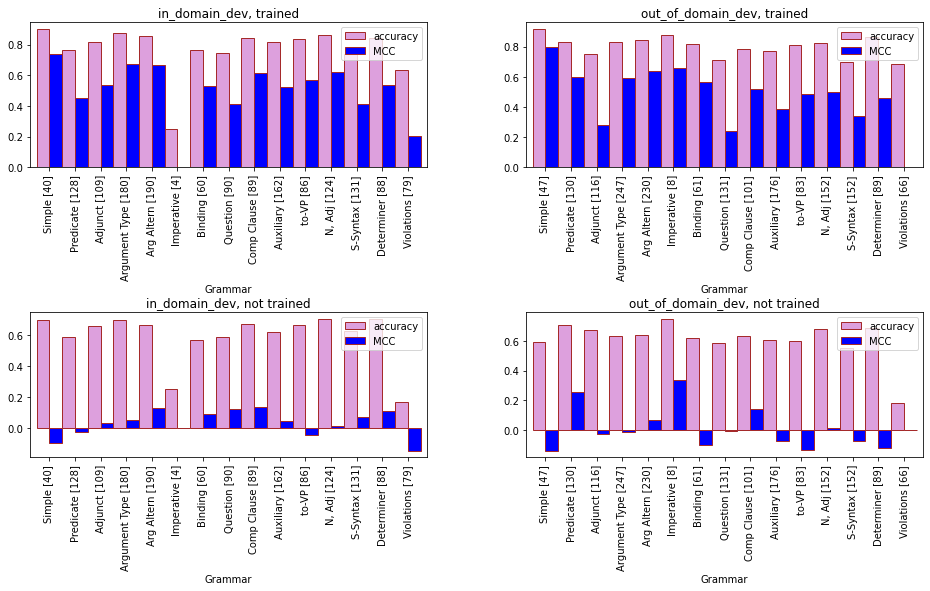

In [57]:
# with dagshub init
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
metrics_in_domain_dev = pd.DataFrame()
metrics_out_domain_dev = pd.DataFrame()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
plt.subplots_adjust(hspace=1, wspace=0.25) 
for i, m in enumerate(["tr", "nt"]):# , "nt"
    for j,ss in enumerate(['in_domain_dev', 'out_of_domain_dev']):# , 'out_of_domain_dev'
        f0 = pd.read_csv("./data/cola_public/raw/" + ss + ".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
        f = add_prediction(f0, model=m, subset=ss)
        f_major = pd.merge(f, gr_major, on='sentence')
        sc = get_scores_by_grammar(f_major)
        metrics_data = metrics_in_domain_dev
        if ss == 'out_of_domain_dev':
            metrics_data = metrics_out_domain_dev
        title = ss
        name_param = 'trained'
        if m == 'tr':
            title += ', trained'
        else:
            title += ', not trained'
            name_param = 'not_trained'
        classes = sc.Grammar.values.copy()
        if metrics_data.empty:
            metrics_data['Grammar'] = sc['Grammar']
            metrics_data['number_of_mistakes'] = sc['Total']

        sc['Grammar'] = sc.apply(lambda x: '%s [%d]' % (x.Grammar, x.Total), axis=1)
        sc_acc = get_scores_by_grammar(f_major, scoring_method=accuracy_score, 
                                       scoring_name='accuracy')
        sc['Grammar_acc'] = sc_acc.apply(lambda x: '%s [%d]' % (x.Grammar, x.Total), axis=1)
        sc['accuracy'] = sc_acc['accuracy']
        metric_names= {metric_name.replace(',', ' ')+ f'_acc':sc_acc['accuracy'].values[k]
            for k, metric_name in enumerate(classes)}
        metrics_data[f'acc_bert_{name_param}'] = sc['accuracy']
        metrics_data[f'mcc_bert_{name_param}'] = sc['MCC']
        sc.plot.bar(x='Grammar', y=['accuracy', 'MCC'], title = title, color = ['plum', 'blue'], 
                    width=1.0, edgecolor = 'brown',ax = ax[i, j])
        logger = DAGsHubLogger(metrics_path=f"logs/test_metrics_{ss}_{name_param}.csv", 
                                hparams_path=f"logs/test_params_{ss}_{name_param}.yml") 
        print('Saved to files', f"logs/test_metrics_{ss}_{name_param}.csv")
        logger.log_metrics(metric_names) 
        logger.log_hyperparams({"model": name_param,"source": ss}) 
        logger.save() 
        logger.close()

In [97]:
tuples = [('fine-tuned', 'mcc'), ('fine-tuned', 'acc'), ('not fine-tuned', 'mcc'), ('not fine-tuned', 'acc')]
index = pd.MultiIndex.from_tuples(tuples)
data = ['in_domain_dev', 'out_of_domain_dev']
metrics_binary_classes = pd.DataFrame(index = data, columns = index)
for i, m in enumerate(["tr", "nt"]):# , "nt"
    for j,ss in enumerate(['in_domain_dev', 'out_of_domain_dev']):# , 'out_of_domain_dev'
        f0 = pd.read_csv("./data/cola_public/raw/" + ss + ".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
        f = add_prediction(f0, model=m, subset=ss)
        f_major = pd.merge(f, gr_major, on='sentence')
        
        mcc = get_general_scores(f_major, scoring_method=matthews_corrcoef)
        acc = get_general_scores(f_major, scoring_method=accuracy_score)
        index_name = 'not fine-tuned'
        if m == "tr":
            index_name = 'fine-tuned'
        metrics_binary_classes.loc[ss, (index_name, 'mcc')] = mcc
        metrics_binary_classes.loc[ss, (index_name, 'acc')] = acc

In [98]:
metrics_binary_classes

fine-tuned           not fine-tuned          
                         mcc       acc            mcc       acc
in_domain_dev       0.592208  0.834915       0.048593  0.650854
out_of_domain_dev   0.596834   0.83463       0.005447   0.63035

# Отбор признаков для nt модели на in_domain_train

<a id='nt_feature_selection'></a>

## p_value

In [ ]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [45]:
features_importances = pd.read_csv(f'{tables_dir}features_importances.csv', index_col=0)
features_importances.head()

,feature,type,p_value,corr,in_train_acc_roc_mcc,in_dev_acc_roc_mcc,out_dev_acc_roc_mcc,in_train_mcc_roc_mcc,in_dev_mcc_roc_mcc,out_dev_mcc_roc_mcc
0,v_t0.75_8_6,topological,1.684520e-120,0.254270,0.680038,0.675522,0.673127,0.219031,0.200834,0.232840
1,v_t0.1_8_6,topological,4.047799e-118,-0.253402,0.691966,0.676154,0.698320,0.202288,0.164001,0.242049
2,h0_t_d_8_6,barcode,4.543650e-107,-0.236393,0.563562,0.574320,0.558786,0.208765,0.226206,0.240258
3,b1_t0.1_8_6,topological,4.863425e-95,-0.200544,0.582738,0.577483,0.569121,0.195701,0.183921,0.217593
4,v_t0.25_8_6,topological,2.697872e-93,-0.228246,0.638523,0.641366,0.653101,0.203697,0.193526,0.264015


In [41]:
subset, model = ('in_domain_train', 'nt')
features_values = pd.read_csv(f"{tables_dir}all_features_{subset}_{model}.csv")

In [42]:
df_in_domain = pd.read_csv("./data/cola_public/raw/in_domain_dev" +".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
X_in_domain = pd.read_csv(f"{tables_dir}all_features_in_domain_dev_{model}.csv")
y_in_domain = df_in_domain['label'].values
df_out_domain = pd.read_csv("./data/cola_public/raw/out_of_domain_dev" +".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
y_out_domain = df_out_domain['label'].values
X_out_domain = pd.read_csv(f"{tables_dir}all_features_out_of_domain_dev_{model}.csv")

In [43]:
features_values = pd.read_csv(f"{tables_dir}all_features_{subset}_{model}.csv")
df = pd.read_csv("./data/cola_public/raw/" + subset + ".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
y = df['label'].values
X = features_values

In [46]:
p_value_30 = features_importances.sort_values(by = 'p_value').feature.values
p_value_30.shape[0]

8928

In [ ]:
max_num = 200 # максимальное число признаков

In [ ]:
#@title Расчет метрик по N min p_value
metrics_dict = defaultdict(list)
trained_ = 'logReg'
for i in tqdm(range(1,max_num)):
    features_i = p_value_30[:i]
    X = features_values.loc[:, features_i].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.25, random_state=1)
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)

    yhat = model.predict_proba(X_test)
    yhat = yhat[:, 1]

    fpr, tpr, threshold = roc_curve(y_test, yhat)
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = threshold[ix]

    acc_str, mcc_str = [], []
    acc_in_domain, mcc_in_domain = [], []
    acc_out_domain, mcc_out_domain = [], []
    acc, mcc = 0, 0
    list_sets = [(X,y, acc_str, mcc_str,
                    'in_domain_train', df['sentence'].values),
                 (X_in_domain.loc[:, features_i].values, y_in_domain, acc_in_domain, mcc_in_domain, 
                  'in_domain_dev', df_in_domain['sentence'].values),
                (X_out_domain.loc[:, features_i].values, y_out_domain, acc_out_domain, mcc_out_domain, 
                 'out_of_domain_dev', df_out_domain['sentence'].values )]
    for sets in list_sets:
        X_test_, y_test_, aucs_, mccs_, file_name, y_texts = sets
        yhat = model.predict_proba(X_test_)
        yhat = yhat[:, 1]
        y_pred = np.array([1 if i>best_thresh else 0 for i in yhat])
        acc, mcc = 0, 0
        acc, mcc = accuracy_score(y_test_, y_pred), matthews_corrcoef(y_test_, y_pred)
        aucs_.append(acc)
        mccs_.append(mcc)
        false_positive = np.argwhere(y_pred>y_test_).reshape(-1) 
        false_positive_sam = np.array(y_texts)[false_positive]
        false_negative = np.argwhere(y_pred<y_test_).reshape(-1) 
        false_negative_sam = np.array(y_texts)[false_negative]
        
        for j, var in zip([f"mistakes/false_positive_sam_{trained_}_{file_name}_p_value_{i}.txt",
                            f"mistakes/false_positive_{trained_}_{file_name}_p_value_{i}.txt",
                        f"mistakes/false_negative_sam_{trained_}_{file_name}_p_value_{i}.txt", 
                        f"mistakes/false_negative_{trained_}_{file_name}_p_value_{i}.txt"], 
                        [false_positive_sam, false_positive,false_negative_sam, false_negative]):
            with open(j, 'w') as output:
                for row in list(var):
                    to_write = row
                    output.write(str(to_write) + '\n')

    for key, list_ in zip(['in_train_acc', 'in_dev_acc', 'out_dev_acc'], 
                          [acc_str, acc_in_domain, acc_out_domain]):
        metrics_dict[key].append(np.mean(list_))

    for key, list_ in zip(['in_train_mcc', 'in_dev_mcc', 'out_dev_mcc'], 
                          [mcc_str, mcc_in_domain, mcc_out_domain]):
        metrics_dict[key].append(np.mean(list_))

  0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


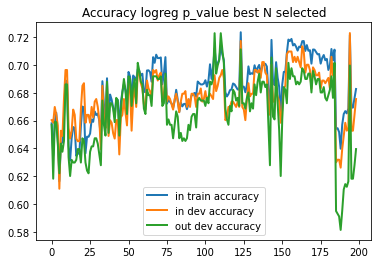

In [ ]:
plt.plot(np.arange(max_num-1), metrics_dict['in_train_acc'], label='in train accuracy', linewidth=2)
plt.plot(np.arange(max_num-1), metrics_dict['in_dev_acc'], label='in dev accuracy', linewidth=2)
plt.plot(np.arange(max_num-1), metrics_dict['out_dev_acc'], label='out dev accuracy', linewidth=2)
plt.title('Accuracy logreg p_value best N selected')
plt.legend(loc='best')
plt.show()

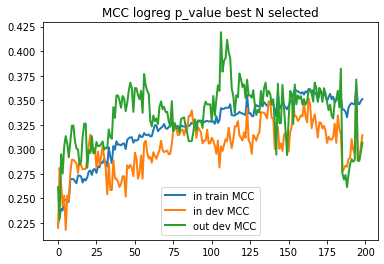

In [ ]:
plt.plot(np.arange(max_num-1), metrics_dict['in_train_mcc'], label='in train MCC', linewidth=2)
plt.plot(np.arange(max_num-1), metrics_dict['in_dev_mcc'], label='in dev MCC', linewidth=2)
plt.plot(np.arange(max_num-1), metrics_dict['out_dev_mcc'], label='out dev MCC', linewidth=2)
plt.title('MCC logreg p_value best N selected')
plt.legend(loc='best')
plt.show()

In [ ]:
np.argmax(metrics_dict['in_train_acc']),np.argmax(metrics_dict['in_dev_acc']),np.argmax(metrics_dict['out_dev_acc'])

(123, 194, 106)

In [ ]:
np.argmax(metrics_dict['in_train_mcc']),np.argmax(metrics_dict['in_dev_mcc']),np.argmax(metrics_dict['out_dev_mcc'])

(194, 194, 106)

In [ ]:
n_max_mcc = np.argmax(metrics_dict['in_train_mcc'])

Saved to files logs/test_metrics_in_domain_dev_log_reg_p_value_194.csv
Saved to files logs/test_metrics_out_of_domain_dev_log_reg_p_value_194.csv


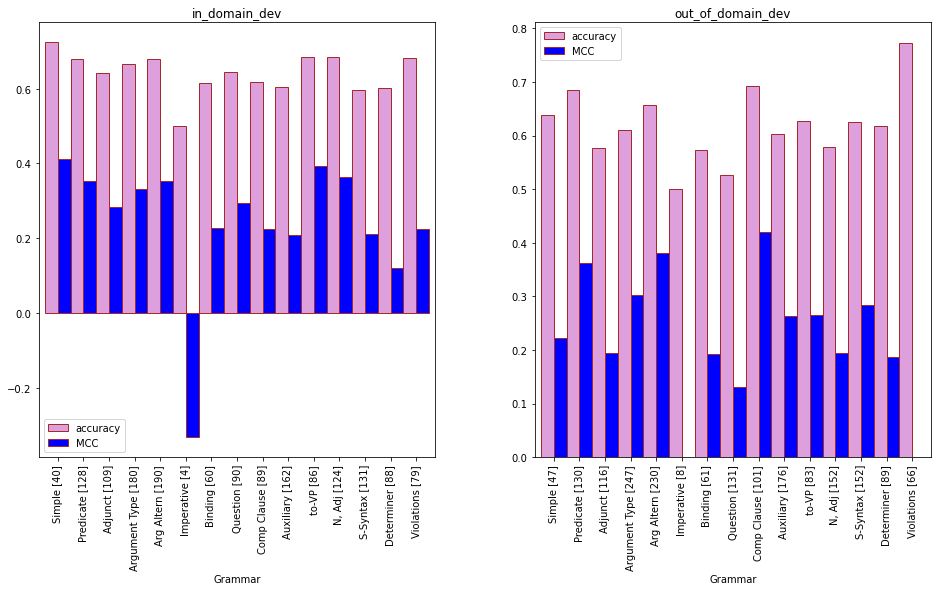

In [58]:
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
plt.subplots_adjust(hspace=1, wspace=0.25) 
for i, m in enumerate([trained_]):# , "nt"
    for j,ss in enumerate(['in_domain_dev', 'out_of_domain_dev']):# , 'out_of_domain_dev'
        f0 = pd.read_csv("./data/cola_public/raw/" + ss + ".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
        f = add_prediction(f0, model=m, subset=ss+f'_p_value_{n_max_mcc}')
        f_major = pd.merge(f, gr_major, on='sentence')
        sc = get_scores_by_grammar(f_major)
        metrics_data = metrics_in_domain_dev
        if ss == 'out_of_domain_dev':
            metrics_data = metrics_out_domain_dev
        title = ss
        name_param = f'log_reg_p_value_{n_max_mcc}'
        classes = sc.Grammar.values.copy()
        if metrics_data.empty:
            metrics_data['Grammar'] = sc['Grammar']
            metrics_data['number_of_mistakes'] = sc['Total']

        sc['Grammar'] = sc.apply(lambda x: '%s [%d]' % (x.Grammar, x.Total), axis=1)
        sc_acc = get_scores_by_grammar(f_major, scoring_method=accuracy_score, scoring_name='accuracy')
        sc['Grammar_acc'] = sc_acc.apply(lambda x: '%s [%d]' % (x.Grammar, x.Total), axis=1)
        sc['accuracy'] = sc_acc['accuracy']
        metric_names= {metric_name.replace(',', ' ')+ f'_acc':sc_acc['accuracy'].values[k]
            for k, metric_name in enumerate(classes)}
        metrics_data[f'acc_{name_param}'] = sc['accuracy']
        metrics_data[f'mcc_{name_param}'] = sc['MCC']

        sc.plot.bar(x='Grammar', y=['accuracy', 'MCC'], title = title, color = ['plum', 'blue'], 
                    width=1.0, edgecolor = 'brown',ax = ax[ j])
        logger = DAGsHubLogger(metrics_path=f"logs/test_metrics_{ss}_{name_param}.csv", 
                                hparams_path=f"logs/test_params_{ss}_{name_param}.yml") 
        print('Saved to files', f"logs/test_metrics_{ss}_{name_param}.csv")

        logger.log_metrics(metric_names) 
        logger.log_hyperparams({"model": name_param,"source": ss}) 
        logger.save() 
        logger.close()

In [99]:
for i, m in enumerate([trained_]):# , "nt"
    for j,ss in enumerate(['in_domain_dev', 'out_of_domain_dev']):# , 'out_of_domain_dev'
        f0 = pd.read_csv("./data/cola_public/raw/" + ss + ".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
        f = add_prediction(f0, model=m, subset=ss+f'_p_value_{n_max_mcc}')
        f_major = pd.merge(f, gr_major, on='sentence')
        mcc = get_general_scores(f_major, scoring_method=matthews_corrcoef)
        acc = get_general_scores(f_major, scoring_method=accuracy_score)
        index_name = f'p_value_{n_max_mcc}'
        metrics_binary_classes.loc[ss, (index_name, 'mcc')] = mcc
        metrics_binary_classes.loc[ss, (index_name, 'acc')] = acc

In [100]:
metrics_binary_classes

fine-tuned           not fine-tuned           p_value_194  \
                         mcc       acc            mcc       acc         mcc   
in_domain_dev       0.592208  0.834915       0.048593  0.650854    0.294770   
out_of_domain_dev   0.596834   0.83463       0.005447   0.63035    0.293967   

                             
                        acc  
in_domain_dev      0.654649  
out_of_domain_dev  0.618677

## correlation

In [62]:
# результаты по корреляции

In [63]:
corr = features_importances.sort_values(by = 'corr', key = abs, ascending = False).feature.values

In [ ]:
#@title Расчет метрик по N max abs corr
metrics_dict = defaultdict(list)
trained_ = 'logReg'
for i in tqdm(range(1,max_num)):
    features_i = corr[:i]
    X = features_values.loc[:, features_i].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.25, random_state=1)
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)

    yhat = model.predict_proba(X_test)
    yhat = yhat[:, 1]

    fpr, tpr, threshold = roc_curve(y_test, yhat)
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = threshold[ix]

    acc_str, mcc_str = [], []
    acc_in_domain, mcc_in_domain = [], []
    acc_out_domain, mcc_out_domain = [], []
    acc, mcc = 0, 0
    list_sets = [(X,y, acc_str, mcc_str,
                    'in_domain_train', df['sentence'].values),
                 (X_in_domain.loc[:, features_i].values, y_in_domain, acc_in_domain, mcc_in_domain, 
                  'in_domain_dev', df_in_domain['sentence'].values),
                (X_out_domain.loc[:, features_i].values, y_out_domain, acc_out_domain, mcc_out_domain, 
                 'out_of_domain_dev', df_out_domain['sentence'].values )]
    for sets in list_sets:
        X_test_, y_test_, aucs_, mccs_, file_name, y_texts = sets
        yhat = model.predict_proba(X_test_)
        yhat = yhat[:, 1]
        y_pred = np.array([1 if i>best_thresh else 0 for i in yhat])
        acc, mcc = 0, 0
        acc, mcc = accuracy_score(y_test_, y_pred), matthews_corrcoef(y_test_, y_pred)
        aucs_.append(acc)
        mccs_.append(mcc)
        false_positive = np.argwhere(y_pred>y_test_).reshape(-1) 
        false_positive_sam = np.array(y_texts)[false_positive]
        false_negative = np.argwhere(y_pred<y_test_).reshape(-1) 
        false_negative_sam = np.array(y_texts)[false_negative]
        
        for j, var in zip([f"mistakes/false_positive_sam_{trained_}_{file_name}_corr_{i}.txt",
                            f"mistakes/false_positive_{trained_}_{file_name}_corr_{i}.txt",
                        f"mistakes/false_negative_sam_{trained_}_{file_name}_corr_{i}.txt", 
                        f"mistakes/false_negative_{trained_}_{file_name}_corr_{i}.txt"], 
                        [false_positive_sam, false_positive,false_negative_sam, false_negative]):
            with open(j, 'w') as output:
                for row in list(var):
                    to_write = row
                    output.write(str(to_write) + '\n')

    for key, list_ in zip(['in_train_acc', 'in_dev_acc', 'out_dev_acc'], 
                          [acc_str, acc_in_domain, acc_out_domain]):
        metrics_dict[key].append(np.mean(list_))

    for key, list_ in zip(['in_train_mcc', 'in_dev_mcc', 'out_dev_mcc'], 
                          [mcc_str, mcc_in_domain, mcc_out_domain]):
        metrics_dict[key].append(np.mean(list_))

  0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


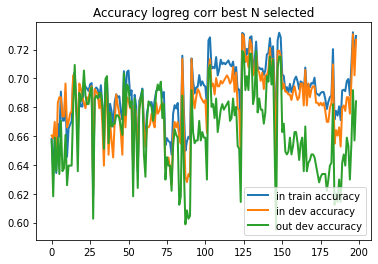

In [ ]:
plt.plot(np.arange(max_num-1), metrics_dict['in_train_acc'], label='in train accuracy', linewidth=2)
plt.plot(np.arange(max_num-1), metrics_dict['in_dev_acc'], label='in dev accuracy', linewidth=2)
plt.plot(np.arange(max_num-1), metrics_dict['out_dev_acc'], label='out dev accuracy', linewidth=2)
plt.title('Accuracy logreg corr best N selected')
plt.legend(loc='best')
plt.show()

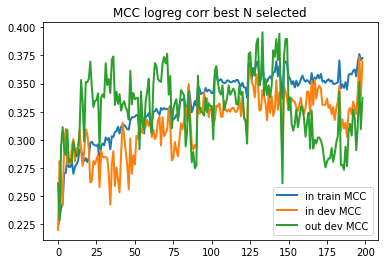

In [ ]:
plt.plot(np.arange(max_num-1), metrics_dict['in_train_mcc'], label='in train MCC', linewidth=2)
plt.plot(np.arange(max_num-1), metrics_dict['in_dev_mcc'], label='in dev MCC', linewidth=2)
plt.plot(np.arange(max_num-1), metrics_dict['out_dev_mcc'], label='out dev MCC', linewidth=2)
plt.title('MCC logreg corr best N selected')
plt.legend(loc='best')
plt.show()

In [ ]:
np.argmax(metrics_dict['in_train_acc']),np.argmax(metrics_dict['in_dev_acc']),np.argmax(metrics_dict['out_dev_acc'])

(196, 124, 124)

In [ ]:
np.argmax(metrics_dict['in_train_mcc']),np.argmax(metrics_dict['in_dev_mcc']),np.argmax(metrics_dict['out_dev_mcc'])

(196, 196, 133)

In [ ]:
n_max_mcc = np.argmax(metrics_dict['in_train_mcc'])

Saved to files logs/test_metrics_in_domain_dev_log_reg_corr_194.csv
Saved to files logs/test_metrics_out_of_domain_dev_log_reg_corr_194.csv


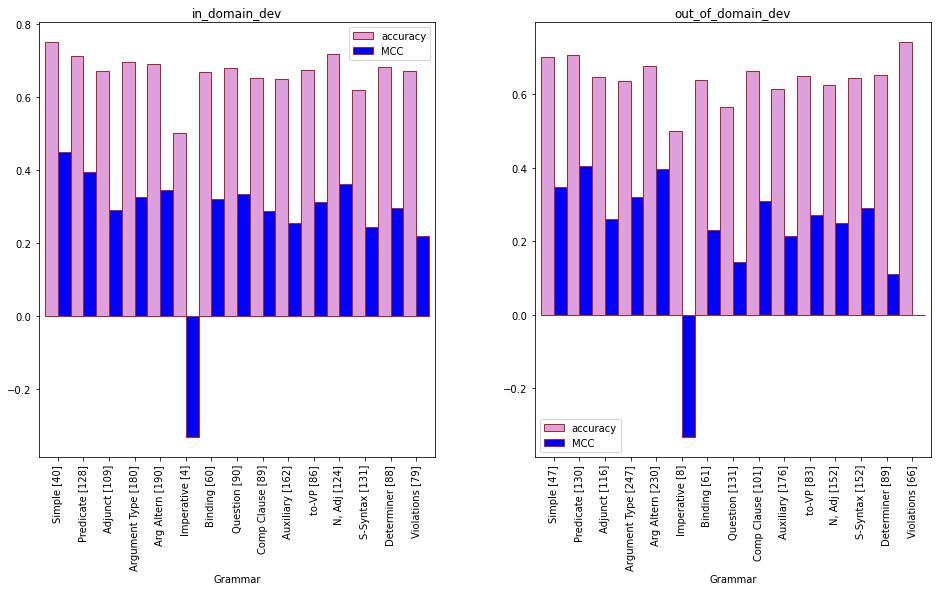

In [65]:
# with dagshub init
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
plt.subplots_adjust(hspace=1, wspace=0.25) 
for i, m in enumerate([trained_]):# , "nt"
    for j,ss in enumerate(['in_domain_dev', 'out_of_domain_dev']):# , 'out_of_domain_dev'
        f0 = pd.read_csv("./data/cola_public/raw/" + ss + ".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
        f = add_prediction(f0, model=m, subset=ss+f'_corr_{n_max_mcc}')
        f_major = pd.merge(f, gr_major, on='sentence')
        sc = get_scores_by_grammar(f_major)
        metrics_data = metrics_in_domain_dev
        if ss == 'out_of_domain_dev':
            metrics_data = metrics_out_domain_dev
        title = ss
        name_param = f'log_reg_corr_{n_max_mcc}'
        classes = sc.Grammar.values.copy()
        if metrics_data.empty:
            metrics_data['Grammar'] = sc['Grammar']
            metrics_data['number_of_mistakes'] = sc['Total']

        sc['Grammar'] = sc.apply(lambda x: '%s [%d]' % (x.Grammar, x.Total), axis=1)
        sc_acc = get_scores_by_grammar(f_major, scoring_method=accuracy_score, scoring_name='accuracy')
        sc['Grammar_acc'] = sc_acc.apply(lambda x: '%s [%d]' % (x.Grammar, x.Total), axis=1)
        sc['accuracy'] = sc_acc['accuracy']
        metric_names= {metric_name.replace(',', ' ')+ f'_acc':sc_acc['accuracy'].values[k]
            for k, metric_name in enumerate(classes)}
        metrics_data[f'acc_{name_param}'] = sc['accuracy']
        metrics_data[f'mcc_{name_param}'] = sc['MCC']

        sc.plot.bar(x='Grammar', y=['accuracy', 'MCC'], title = title, color = ['plum', 'blue'], 
                    width=1.0, edgecolor = 'brown',ax = ax[j])
        logger = DAGsHubLogger(metrics_path=f"logs/test_metrics_{ss}_{name_param}.csv", 
                                hparams_path=f"logs/test_params_{ss}_{name_param}.yml") 
        
        print('Saved to files', f"logs/test_metrics_{ss}_{name_param}.csv")

        logger.log_metrics(metric_names) 
        logger.log_hyperparams({"model": name_param,"source": ss}) 
        logger.save() 
        logger.close()

In [103]:
for i, m in enumerate([trained_]):
    for j,ss in enumerate(['in_domain_dev', 'out_of_domain_dev']):
        f0 = pd.read_csv("./data/cola_public/raw/" + ss + ".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
        f = add_prediction(f0, model=m, subset=ss+f'_corr_{n_max_mcc}')
        f_major = pd.merge(f, gr_major, on='sentence')
        mcc = get_general_scores(f_major, scoring_method=matthews_corrcoef)
        acc = get_general_scores(f_major, scoring_method=accuracy_score)
        index_name = f'corr_{n_max_mcc}'
        metrics_binary_classes.loc[ss, (index_name, 'mcc')] = mcc
        metrics_binary_classes.loc[ss, (index_name, 'acc')] = acc

In [104]:
metrics_binary_classes

fine-tuned           not fine-tuned           p_value_194  \
                         mcc       acc            mcc       acc         mcc   
in_domain_dev       0.592208  0.834915       0.048593  0.650854    0.294770   
out_of_domain_dev   0.596834   0.83463       0.005447   0.63035    0.293967   

                             corr_196            
                        acc       mcc       acc  
in_domain_dev      0.654649  0.341366  0.698292  
out_of_domain_dev  0.618677  0.325518  0.661479

# sklearn feature selection

In [105]:
df = pd.read_csv("./data/cola_public/raw/" + subset + ".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
y = df['label'].values
X = features_values

In [ ]:
%%time
params = {'tol': 1e-6, 'max_iter': 100000, 'random_state': 1}

pipeline = Pipeline([
    ('drop_constants', VarianceThreshold(threshold=0.0001)), # SelectKBest() reported about many constant features
    ('scaler', StandardScaler()),
    ('reduce_dim', PCA(whiten=True, random_state=1)),
    ('clf', LogisticRegression(**params)), # FIXME try other classifiers
])

N_FEATURES_OPTIONS = [5, 10, 20, 40, 80, 100, 200, 500, 505]# [5, 10, 20, 40, 80, 100, 200, 500, 505] np.arange(501,502)
C_OPTIONS = np.logspace(-1, 2, num=4)# np.logspace(-1, 2, num=4) [1] 
# 'saga' solver needs data scaling (and still sometimes doesn't converge and is not better than 'liblinear'),
# 'lbfgs' doesn't work with 'l1'
CLF_SOLVER_OPTIONS = ['liblinear']# , 'liblinear', 'saga'
CLF_PENALTY_OPTIONS = ['l1'] # 'l2', 'l1' 
CLASS_WEIGHT = [None] # for 'balanced' it's worse

params_grid = {
    'reduce_dim__n_components': N_FEATURES_OPTIONS,
    'clf__C': C_OPTIONS, 
    'clf__solver': CLF_SOLVER_OPTIONS,
    'clf__penalty': CLF_PENALTY_OPTIONS,
    # 'clf__class_weight': CLASS_WEIGHT,
    }

# SelectKBest is not better than PCA
# SelectKBest(chi2) is for non-negative features only
"""
    {
    'reduce_dim': [SelectKBest()],
    'reduce_dim__k': N_FEATURES_OPTIONS,
    'clf__C': C_OPTIONS, 
     # 'saga' needs data scaling (and still doesn't converge), 'lbfgs' doesn't work with 'l1'
    'clf__solver': CLF_SOLVER_OPTIONS,
    'clf__penalty': CLF_PENALTY_OPTIONS,
    'clf__class_weight': CLASS_WEIGHT,
    },
"""

# group shuffle split 
clf = GridSearchCV(pipeline, cv=3, verbose=4, param_grid=params_grid)
start = time()
clf.fit(X, y)


print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(clf.cv_results_['params'])))
report(clf.cv_results_, n_top=10)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=5, score=0.717, total=   8.8s
[CV] clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV]  clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=5, score=0.693, total=   6.2s
[CV] clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s


[CV]  clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=5, score=0.706, total=   6.0s
[CV] clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=10 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.1s remaining:    0.0s


[CV]  clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=10, score=0.718, total=   6.2s
[CV] clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=10 
[CV]  clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=10, score=0.705, total=   6.1s
[CV] clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=10 
[CV]  clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=10, score=0.716, total=   6.1s
[CV] clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=20 
[CV]  clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=20, score=0.729, total=   6.8s
[CV] clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=20 
[CV]  clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=20, score=0.713, total=   6.9s
[CV] clf__C=0.1, clf__penalty=l1, clf__solver=liblinear, reduce_dim__n_components=20 


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 25.1min finished


GridSearchCV took 1526.59 seconds for 36 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.733 (std: 0.002)
Parameters: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'reduce_dim__n_components': 200}

Model with rank: 2
Mean validation score: 0.732 (std: 0.005)
Parameters: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'reduce_dim__n_components': 100}

Model with rank: 3
Mean validation score: 0.732 (std: 0.009)
Parameters: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'reduce_dim__n_components': 505}

Model with rank: 4
Mean validation score: 0.732 (std: 0.004)
Parameters: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'reduce_dim__n_components': 80}

Model with rank: 5
Mean validation score: 0.732 (std: 0.002)
Parameters: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'reduce_dim__n_components': 80}

Model with rank: 6
Mean validation score: 0.732 (std: 0.005)
Param

In [ ]:
clf.best_params_

{'clf__C': 0.1,
 'clf__penalty': 'l1',
 'clf__solver': 'liblinear',
 'reduce_dim__n_components': 200}

In [ ]:
#@title complementary functions
def confusion_matrix_curve(y, yhat):
    p = np.sum(y)
    n = y.shape[0] - p
    fpr, tpr, threshold = roc_curve(y, yhat)
    tns = []
    fps = []
    fns = []
    tps = []
    for i in range(len(fpr)):
        fp = fpr[i] * n
        tp = tpr[i] * p
        tn = n - fp
        fn = p - tp
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
        tps.append(tp)
    return np.array(tns), np.array(fps), np.array(fns), np.array(tps), threshold

def compute_mcc(tns, fps, fns, tps):
    a = []
    for i in range(len(tns)):
        top = tps[i] * tns[i] - fps[i] * fns[i]
        if top == 0:
            a.append(0)
        else:
            bottom = np.sqrt((tps[i] + fps[i]) * (tps[i] + fns[i]) * (tns[i] + fps[i]) * (tns[i] + fns[i]))
            a.append(top / bottom)
    return np.array(a)

def find_best_threshold(y, yhat, scoring='balanced_accuracy'):
    if scoring == 'balanced_accuracy':
        fpr, tpr, threshold = roc_curve(y, yhat)
        thr = threshold[np.argmax(tpr - fpr)] # max. tpr - fpr => max. balanced accuracy
        y_pred = np.array([1 if i > thr else 0 for i in yhat])
    elif scoring == 'matthews_corrcoef':
        tns, fps, fns, tps, threshold = confusion_matrix_curve(y, yhat)
        mccs = compute_mcc(tns, fps, fns, tps)
        thr = threshold[np.argmax(mccs)]
        y_pred = np.array([1 if i > thr else 0 for i in yhat])
    else:
        print('Unknown scoring', file=sys.stderr)
        assert 0
    return thr, y_pred

def print_thresholds(y, yhat, verbose=True):
    for s in ['balanced_accuracy', 'matthews_corrcoef']:
        thr, y_pred = find_best_threshold(y, yhat, scoring=s)
        bal_acc, acc, mcc = balanced_accuracy_score(y, y_pred), accuracy_score(y, y_pred), matthews_corrcoef(y, y_pred)
        if (verbose):
            print('Search for the best threshold by maximizing "', s, '":', sep='')
            print('Threshold =', thr, sep='\t')
            print('Bal. Acc. =', bal_acc, sep='\t')
            print('Accuracy =', acc, sep='\t')
            print('MCC score =', mcc, '\n', sep='\t')
    return thr, mcc, y_pred

def print_scores(y, y_pred):
    bal_acc, acc, mcc = balanced_accuracy_score(y, y_pred), accuracy_score(y, y_pred), matthews_corrcoef(y, y_pred)
    print('Bal. Acc. =', bal_acc, sep='\t')
    print('Accuracy =', acc, sep='\t')
    print('MCC score =', mcc, '\n', sep='\t')


In [ ]:
yhat0 = clf.predict_proba(X)
yhat = yhat0[:, 1]

print_thresholds(y, yhat)
print(clf)
print(clf.best_params_)

Search for the best threshold by maximizing "balanced_accuracy":
Threshold =	0.7120457716800083
Bal. Acc. =	0.7135950178850272
Accuracy =	0.7182785639106537
MCC score =	0.3977138737524574	

Search for the best threshold by maximizing "matthews_corrcoef":
Threshold =	0.5692604436912491
Bal. Acc. =	0.6843441123373062
Accuracy =	0.7680972985615717
MCC score =	0.4063149711100669	

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('drop_constants',
                                        VarianceThreshold(threshold=0.0001)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('reduce_dim',
                                        PCA(copy=True, iterated_power='auto',
            

In [68]:
model = 'nt'
df_in_domain = pd.read_csv("./data/cola_public/raw/in_domain_dev" +".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
X_in_domain = pd.read_csv(f"{tables_dir}all_features_in_domain_dev_{model}.csv")
y_in_domain = df_in_domain['label'].values
df_out_domain = pd.read_csv("./data/cola_public/raw/out_of_domain_dev" +".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
y_out_domain = df_out_domain['label'].values
X_out_domain = pd.read_csv(f"{tables_dir}all_features_out_of_domain_dev_{model}.csv")
X_out_domain.head(2)

,s_t0.025_0_0,s_t0.05_0_0,s_t0.1_0_0,s_t0.25_0_0,s_t0.5_0_0,s_t0.75_0_0,w_t0.025_0_0,w_t0.05_0_0,w_t0.1_0_0,w_t0.25_0_0,...,prev_11_10,next_11_10,comma_11_10,dot_11_10,self_11_11,beginning_11_11,prev_11_11,next_11_11,comma_11_11,dot_11_11
0,1.0,1.0,2.0,9.0,9.0,9.0,1.0,1.0,1.0,8.0,...,0.992188,0.986816,1.000000,0.986328,0.986902,0.972257,0.994141,0.98877,1.000000,0.995117
1,1.0,3.0,21.0,22.0,22.0,22.0,1.0,1.0,15.0,22.0,...,0.987305,0.986328,0.803711,0.748047,0.984134,0.987389,0.985840,0.98584,0.794434,0.736328


In [ ]:
y_pred = clf.predict(X_out_domain)
print_scores(y_out_domain, y_pred)

Bal. Acc. =	0.6551579828415987
Accuracy =	0.751937984496124
MCC score =	0.37311534156987886	



In [ ]:
n_max_mcc = clf.best_params_['reduce_dim__n_components']

In [ ]:
#@title Расчет метрик logreg gridsearchcv
trained_ = 'grid_search_cv'

yhat = clf.predict_proba(X)
yhat = yhat[:, 1]

fpr, tpr, threshold = roc_curve(y, yhat)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = threshold[ix]

acc_str, mcc_str = [], []
acc_in_domain, mcc_in_domain = [], []
acc_out_domain, mcc_out_domain = [], []
acc, mcc = 0, 0
list_sets = [(X,y, acc_str, mcc_str,
                'in_domain_train', df['sentence'].values),
                (X_in_domain.values, y_in_domain, acc_in_domain, mcc_in_domain, 
                'in_domain_dev', df_in_domain['sentence'].values),
            (X_out_domain.values, y_out_domain, acc_out_domain, mcc_out_domain, 
                'out_of_domain_dev', df_out_domain['sentence'].values )]
for sets in list_sets:
    X_test_, y_test_, aucs_, mccs_, file_name, y_texts = sets
    yhat = clf.predict_proba(X_test_)
    yhat = yhat[:, 1]
    y_pred = np.array([1 if i>best_thresh else 0 for i in yhat])
    false_positive = np.argwhere(y_pred>y_test_).reshape(-1) 
    false_positive_sam = np.array(y_texts)[false_positive]
    false_negative = np.argwhere(y_pred<y_test_).reshape(-1) 
    false_negative_sam = np.array(y_texts)[false_negative]
    
    for i, var in zip([f"mistakes/false_positive_sam_{trained_}_{file_name}_grid_search_{n_max_mcc}.txt",
                        f"mistakes/false_positive_{trained_}_{file_name}_grid_search_{n_max_mcc}.txt",
                    f"mistakes/false_negative_sam_{trained_}_{file_name}_grid_search_{n_max_mcc}.txt", 
                    f"mistakes/false_negative_{trained_}_{file_name}_grid_search_{n_max_mcc}.txt"], 
                    [false_positive_sam, false_positive,false_negative_sam, false_negative]):
        with open(i, 'w') as output:
            for row in list(var):
                to_write = row
                output.write(str(to_write) + '\n')

Saved to files logs/test_metrics_in_domain_dev_log_reg_grid_search_200.csv
Saved to files logs/test_metrics_out_of_domain_dev_log_reg_grid_search_200.csv


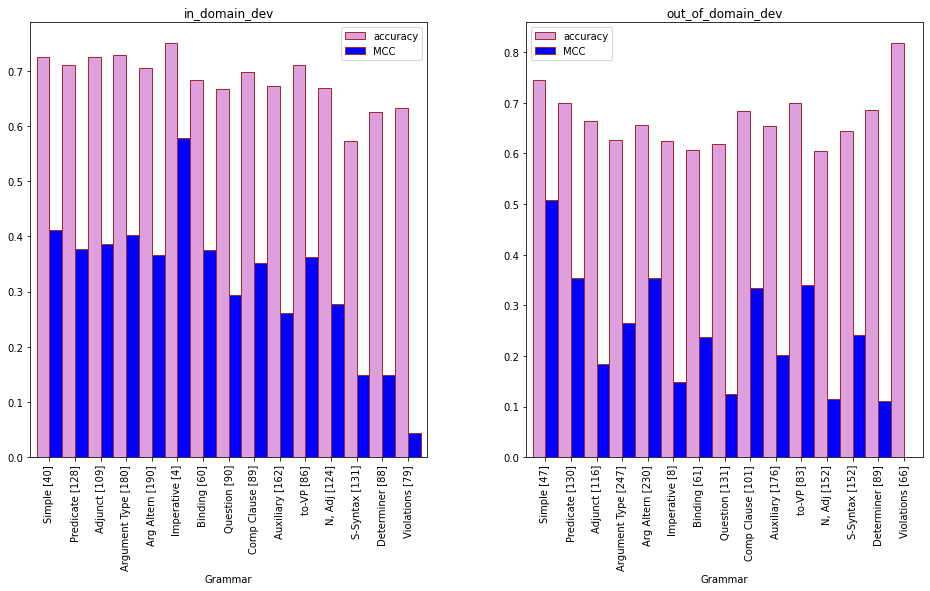

In [71]:
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
plt.subplots_adjust(hspace=1, wspace=0.25) 
for i, m in enumerate([trained_]):# , "nt"
    for j,ss in enumerate(['in_domain_dev', 'out_of_domain_dev']):# , 'out_of_domain_dev'
        f0 = pd.read_csv("./data/cola_public/raw/" + ss + ".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
        f = add_prediction(f0, model=m, subset=ss+f'_grid_search_{n_max_mcc}')
        f_major = pd.merge(f, gr_major, on='sentence')
        sc = get_scores_by_grammar(f_major)
        metrics_data = metrics_in_domain_dev
        if ss == 'out_of_domain_dev':
            metrics_data = metrics_out_domain_dev
        title = ss
        name_param = f'log_reg_grid_search_{n_max_mcc}'
        classes = sc.Grammar.values.copy()
        if metrics_data.empty:
            metrics_data['Grammar'] = sc['Grammar']
            metrics_data['number_of_mistakes'] = sc['Total']

        sc['Grammar'] = sc.apply(lambda x: '%s [%d]' % (x.Grammar, x.Total), axis=1)
        sc_acc = get_scores_by_grammar(f_major, scoring_method=accuracy_score, scoring_name='accuracy')
        sc['Grammar_acc'] = sc_acc.apply(lambda x: '%s [%d]' % (x.Grammar, x.Total), axis=1)
        sc['accuracy'] = sc_acc['accuracy']
        metric_names= {metric_name.replace(',', ' ')+ f'_acc':sc_acc['accuracy'].values[k]
            for k, metric_name in enumerate(classes)}
        metrics_data[f'acc_{name_param}'] = sc['accuracy']
        metrics_data[f'mcc_{name_param}'] = sc['MCC']


        sc.plot.bar(x='Grammar', y=['accuracy', 'MCC'], title = title, color = ['plum', 'blue'], 
                    width=1.0, edgecolor = 'brown',ax = ax[ j])
        


        logger = DAGsHubLogger(metrics_path=f"logs/test_metrics_{ss}_{name_param}.csv", 
                                hparams_path=f"logs/test_params_{ss}_{name_param}.yml") 
        
        print('Saved to files', f"logs/test_metrics_{ss}_{name_param}.csv")

        logger.log_metrics(metric_names) 
        logger.log_hyperparams({"model": name_param,"source": ss}) 
        logger.save() 
        logger.close()

In [108]:
for i, m in enumerate([trained_]):# , "nt"
    for j,ss in enumerate(['in_domain_dev', 'out_of_domain_dev']):# , 'out_of_domain_dev'
        f0 = pd.read_csv("./data/cola_public/raw/" + ss + ".tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
        f = add_prediction(f0, model=m, subset=ss+f'_grid_search_{n_max_mcc}')
        f_major = pd.merge(f, gr_major, on='sentence')
        mcc = get_general_scores(f_major, scoring_method=matthews_corrcoef)
        acc = get_general_scores(f_major, scoring_method=accuracy_score)
        index_name = f'_grid_search_{n_max_mcc}'
        metrics_binary_classes.loc[ss, (index_name, 'mcc')] = mcc
        metrics_binary_classes.loc[ss, (index_name, 'acc')] = acc

In [109]:
metrics_in_domain_dev.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Grammar,Simple,Predicate,Adjunct,Argument Type,Arg Altern,Imperative,Binding,Question,Comp Clause,Auxiliary,to-VP,"N, Adj",S-Syntax,Determiner,Violations
number_of_mistakes,40,128,109,180,190,4,60,90,89,162,86,124,131,88,79
acc_bert_trained,0.9,0.765625,0.816514,0.877778,0.852632,0.25,0.766667,0.744444,0.842697,0.814815,0.837209,0.862903,0.740458,0.840909,0.632911
mcc_bert_trained,0.74079,0.452283,0.53731,0.672119,0.665343,0.0,0.527119,0.415227,0.611856,0.523712,0.568572,0.618198,0.409156,0.538122,0.200544
acc_bert_not_trained,0.7,0.585938,0.66055,0.7,0.663158,0.25,0.566667,0.588889,0.674157,0.617284,0.662791,0.701613,0.625954,0.704545,0.164557
mcc_bert_not_trained,-0.09862,-0.024635,0.034873,0.050252,0.12943,0.0,0.089131,0.121681,0.136595,0.046967,-0.04333,0.010455,0.071283,0.107624,-0.145805
acc_log_reg_p_value_194,0.725,0.679688,0.642202,0.666667,0.678947,0.5,0.616667,0.644444,0.617978,0.604938,0.686047,0.685484,0.59542,0.602273,0.683544
mcc_log_reg_p_value_194,0.411435,0.353702,0.283733,0.331299,0.353634,-0.333333,0.228317,0.295122,0.223684,0.20865,0.392296,0.363797,0.210331,0.120645,0.223661
acc_log_reg_corr_194,0.75,0.710938,0.669725,0.694444,0.689474,0.5,0.666667,0.677778,0.651685,0.648148,0.674419,0.717742,0.618321,0.681818,0.670886
mcc_log_reg_corr_194,0.448147,0.393429,0.290813,0.325574,0.345402,-0.333333,0.319582,0.33414,0.288181,0.255537,0.312847,0.359803,0.244445,0.296432,0.217508


In [110]:
metrics_out_domain_dev.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Grammar,Simple,Predicate,Adjunct,Argument Type,Arg Altern,Imperative,Binding,Question,Comp Clause,Auxiliary,to-VP,"N, Adj",S-Syntax,Determiner,Violations
number_of_mistakes,47,130,116,247,230,8,61,131,101,176,83,152,152,89,66
acc_bert_trained,0.914894,0.830769,0.75,0.82996,0.843478,0.875,0.819672,0.709924,0.782178,0.772727,0.807229,0.822368,0.697368,0.865169,0.681818
mcc_bert_trained,0.798164,0.597622,0.279227,0.59376,0.638177,0.654654,0.56274,0.243529,0.518166,0.38588,0.486205,0.498102,0.341693,0.457603,0.0
acc_bert_not_trained,0.595745,0.707692,0.672414,0.631579,0.643478,0.75,0.622951,0.587786,0.633663,0.607955,0.60241,0.684211,0.552632,0.685393,0.181818
mcc_bert_not_trained,-0.141798,0.252496,-0.029281,-0.015815,0.063595,0.333333,-0.10328,-0.012448,0.137853,-0.073801,-0.135113,0.012168,-0.075443,-0.121904,0.0
acc_log_reg_p_value_194,0.638298,0.684615,0.577586,0.611336,0.656522,0.5,0.57377,0.526718,0.693069,0.602273,0.626506,0.578947,0.625,0.617978,0.772727
mcc_log_reg_p_value_194,0.221879,0.361392,0.193581,0.303504,0.380591,0.0,0.193317,0.130456,0.420962,0.263136,0.264823,0.193505,0.283227,0.187435,0.0
acc_log_reg_corr_194,0.702128,0.707692,0.646552,0.635628,0.678261,0.5,0.639344,0.564885,0.663366,0.613636,0.650602,0.625,0.644737,0.651685,0.742424
mcc_log_reg_corr_194,0.348209,0.405735,0.261122,0.321454,0.396546,-0.333333,0.231277,0.143011,0.310707,0.214307,0.272895,0.249021,0.290543,0.111532,0.0


In [111]:
metrics_binary_classes

fine-tuned           not fine-tuned           p_value_194  \
                         mcc       acc            mcc       acc         mcc   
in_domain_dev       0.592208  0.834915       0.048593  0.650854    0.294770   
out_of_domain_dev   0.596834   0.83463       0.005447   0.63035    0.293967   

                             corr_196           _grid_search_200            
                        acc       mcc       acc              mcc       acc  
in_domain_dev      0.654649  0.341366  0.698292          0.32442  0.690702  
out_of_domain_dev  0.618677  0.325518  0.661479          0.31885  0.667315

In [116]:
# !mkdir results_metrics

In [113]:
metrics_out_domain_dev.to_csv('./results_metrics/metrics_out_domain_dev.csv')

In [114]:
metrics_in_domain_dev.to_csv('./results_metrics/metrics_in_domain_dev.csv')

In [115]:
metrics_in_domain_dev.to_csv('./results_metrics/metrics_binary.csv')